In [15]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [16]:
import gc
gc.collect()

2120

In [17]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Sep 14 11:33:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 44%   65C    P2             225W / 250W |   2112MiB / 11264MiB |     98%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self,  output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

    

Using device: cuda


In [19]:
from stable_baselines3.common.env_util import make_atari_env
env_id="MsPacmanNoFrameskip-v4"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
# print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_atari_env(env_id, n_envs=1,wrapper_kwargs={"clip_reward":False})
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
env = VecTransposeImage(env)            # 确保图像通道在前
env = VecFrameStack(env, n_stack=4)     # 堆叠4帧
obs = env.reset()
print(obs.shape)
# print(env.action_space.n)
# print(env.observation_space.shape[0])

(1154, 4, 84, 84) (1154,) (1154,) (1154,) (1154,) (1154, 4, 84, 84)
(1, 4, 84, 84)


In [20]:
mean=observations.mean(axis=0)
std=observations.std(axis=0)
print(mean.shape, std.shape)
print(mean, std)

(4, 84, 84) (4, 84, 84)
[[[ 87.31369151  87.31369151  66.47746967 ...  66.47746967  87.31369151
    87.31369151]
  [144.86135182 144.86135182  42.66464471 ...  42.66464471 144.86135182
   144.86135182]
  [144.86135182 144.86135182  42.66464471 ...  42.66464471 144.86135182
   144.86135182]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]]

 [[ 87.54246101  87.54246101  66.65164645 ...  66.65164645  87.54246101
    87.54246101]
  [145.24090121 145.24090121  42.77642981 ...  42.77642981 145.24090121
   145.24090121]
  [145.24090121 145.24090121  42.77642981 ...  42.77642981 145.24090121
   145.24090121]
  ...
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.   

In [21]:
# 导入IPython显示控制模块

from tqdm import tqdm
policy_network = PolicyNetwork(env.action_space.n).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.conv1.weight)
torch.nn.init.kaiming_normal_(policy_network.conv2.weight)
torch.nn.init.kaiming_normal_(policy_network.conv3.weight)
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)

# prev = PolicyNetwork(env.action_space.n).to(device)
# prev.load_state_dict(policy_network.state_dict())
# prev.eval()

# optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-4,weight_decay=1e-3)
optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-4)

# Training loop
num_epochs = 100000
batch_size = observations.shape[0]
mean=observations.mean()
std=observations.std()
print(mean.shape, std.shape)

Normlization=True
# dataset = mydataset(observations=observations, actions=actions)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
normalize_obs= (observations-mean)/std
loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
num_test = 1
if Normlization:
    obs_batch = torch.tensor(np.array(normalize_obs), dtype=torch.float32).to(device)
else:
    obs_batch = torch.tensor(np.array(observations), dtype=torch.float32).to(device)
act_batch = torch.tensor(np.array(actions), dtype=torch.float32).to(device)
test_score=0
for epoch in tqdm(range(1,1+num_epochs)):
    policy_network.train()

    # for step, (obs_batch,act_batch) in enumerate(pbar):
    


    
    logits = policy_network(obs_batch)
    model_dist = Categorical(logits=logits)
    model_act_sample = model_dist.sample()
    policy_chosen_logps = model_dist.log_prob(act_batch)
    policy_rejected_logps = model_dist.log_prob(model_act_sample)
        # with torch.no_grad():
        #     prev_dist = Categorical(logits=prev(obs_batch))
        #     reference_chosen_logps = prev_dist.log_prob(act_batch)
        #     reference_rejected_logps = prev_dist.log_prob(model_act_sample)


    pi_logratios = policy_chosen_logps - policy_rejected_logps
        # ref_logratios = reference_chosen_logps - reference_rejected_logps

    logits = pi_logratios

    chosen_logratios = policy_chosen_logps 
    reject_logratios = policy_rejected_logps


    beta = 0.5
    # losses = (-F.logsigmoid(beta * logits))-policy_chosen_logps
    losses = (-F.logsigmoid(beta * logits))
    # losses = -policy_chosen_logps
    loss = losses.mean()
    # Optimize the policy
    optimizer.zero_grad()



    loss.backward()

    optimizer.step()
    # pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
    positive_reward = chosen_logratios.detach().mean().item()
    negative_reward = reject_logratios.detach().mean().item()
    margin = positive_reward - negative_reward
    loss_graph.append(loss.detach().item())
    margin_graph.append(margin)
    positive_reward_graph.append(positive_reward)
    negative_reward_graph.append(negative_reward)
    # pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward, "test_score": test_score})

    if epoch % 500 == 0:
        total_reward=0

        policy_network.eval()  # 切换到评估模式


        total_reward=0
        # test the policy and save as the first test as gif
        frames = []
        saved_frame = False
        for _ in range(num_test):
            state = env.reset()
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
            if not saved_frame:
                saved_frame = True
                image_path = f"test_{epoch}.gif"
                imageio.mimsave("./gif/"+image_path, frames, duration=40)
        # print(total_reward/num_test)
        test_score = total_reward/num_test
        eval_rewards.append(total_reward/num_test)
        policy_network.train()  # 切换回训练模式
        print(f"Epoch [{epoch}/{num_epochs}] loss: {loss.detach().item()} positive_reward: {positive_reward} negative_reward: {negative_reward} margin: {positive_reward - negative_reward} test_score: {test_score}")


    



() ()


  0%|          | 495/100000 [00:17<36:50, 45.02it/s]  /mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
  1%|          | 504/100000 [00:22<6:40:46,  4.14it/s]

Epoch [500/100000] loss: 0.6643146872520447 positive_reward: -0.09995261579751968 negative_reward: -0.28278884291648865 margin: 0.18283622711896896 test_score: [1640.]


  1%|          | 1003/100000 [00:44<7:34:02,  3.63it/s]

Epoch [1000/100000] loss: 0.6809897422790527 positive_reward: -0.03618340566754341 negative_reward: -0.11420486867427826 margin: 0.07802146300673485 test_score: [980.]


  2%|▏         | 1503/100000 [01:05<5:29:35,  4.98it/s]

Epoch [1500/100000] loss: 0.6847369074821472 positive_reward: -0.026334693655371666 negative_reward: -0.09078636765480042 margin: 0.06445167399942875 test_score: [320.]


  2%|▏         | 2002/100000 [01:28<7:40:13,  3.55it/s]

Epoch [2000/100000] loss: 0.6892733573913574 positive_reward: -0.01048835925757885 negative_reward: -0.04409976303577423 margin: 0.03361140377819538 test_score: [420.]


  3%|▎         | 2509/100000 [01:50<4:06:29,  6.59it/s]

Epoch [2500/100000] loss: 0.6902137994766235 positive_reward: -0.0063550337217748165 negative_reward: -0.029063615947961807 margin: 0.02270858222618699 test_score: [360.]


  3%|▎         | 3005/100000 [02:16<13:20:00,  2.02it/s]

Epoch [3000/100000] loss: 0.6883550882339478 positive_reward: -0.005063156131654978 negative_reward: -0.048837948590517044 margin: 0.043774792458862066 test_score: [3240.]


  4%|▎         | 3505/100000 [02:40<7:33:14,  3.55it/s] 

Epoch [3500/100000] loss: 0.6803410053253174 positive_reward: -0.03472156450152397 negative_reward: -0.12424221634864807 margin: 0.0895206518471241 test_score: [1160.]


  4%|▍         | 4004/100000 [03:06<13:18:20,  2.00it/s]

Epoch [4000/100000] loss: 0.6875889897346497 positive_reward: -0.014020361006259918 negative_reward: -0.05882958695292473 margin: 0.04480922594666481 test_score: [3240.]


  5%|▍         | 4507/100000 [03:27<4:45:37,  5.57it/s] 

Epoch [4500/100000] loss: 0.688835620880127 positive_reward: -0.008114381693303585 negative_reward: -0.042290765792131424 margin: 0.03417638409882784 test_score: [1210.]


  5%|▌         | 5007/100000 [03:51<7:30:15,  3.52it/s] 

Epoch [5000/100000] loss: 0.6899556517601013 positive_reward: -0.004683138802647591 negative_reward: -0.03129560500383377 margin: 0.02661246620118618 test_score: [490.]


  6%|▌         | 5505/100000 [04:14<5:59:16,  4.38it/s]

Epoch [5500/100000] loss: 0.6907423734664917 positive_reward: -0.003213848453015089 negative_reward: -0.020792055875062943 margin: 0.017578207422047853 test_score: [250.]


  6%|▌         | 6005/100000 [04:37<9:56:52,  2.62it/s] 

Epoch [6000/100000] loss: 0.6920290589332581 positive_reward: -0.00279729044996202 negative_reward: -0.01324525661766529 margin: 0.010447966167703271 test_score: [1350.]


  7%|▋         | 6503/100000 [05:01<8:35:44,  3.02it/s] 

Epoch [6500/100000] loss: 0.6853667497634888 positive_reward: -0.01731245033442974 negative_reward: -0.07387762516736984 margin: 0.0565651748329401 test_score: [420.]


  7%|▋         | 7002/100000 [05:27<11:23:16,  2.27it/s]

Epoch [7000/100000] loss: 0.688948392868042 positive_reward: -0.0057242740876972675 negative_reward: -0.042380765080451965 margin: 0.0366564909927547 test_score: [3240.]


  8%|▊         | 7504/100000 [05:53<10:17:42,  2.50it/s]

Epoch [7500/100000] loss: 0.690498411655426 positive_reward: -0.0037753863725811243 negative_reward: -0.026239225640892982 margin: 0.022463839268311858 test_score: [3240.]


  8%|▊         | 8001/100000 [06:18<13:03:25,  1.96it/s]

Epoch [8000/100000] loss: 0.6890738606452942 positive_reward: -0.002929981332272291 negative_reward: -0.03776006028056145 margin: 0.034830078948289156 test_score: [3240.]


  9%|▊         | 8502/100000 [06:39<10:46:10,  2.36it/s]

Epoch [8500/100000] loss: 0.6916088461875916 positive_reward: -0.0021215423475950956 negative_reward: -0.014499925076961517 margin: 0.012378382729366422 test_score: [3240.]


  9%|▉         | 9004/100000 [07:00<3:44:40,  6.75it/s] 

Epoch [9000/100000] loss: 0.6931471824645996 positive_reward: -0.0014690229436382651 negative_reward: -0.0014690229436382651 margin: 0.0 test_score: [270.]


 10%|▉         | 9504/100000 [07:25<11:02:38,  2.28it/s]

Epoch [9500/100000] loss: 0.6925727725028992 positive_reward: -0.004664793610572815 negative_reward: -0.010699584148824215 margin: 0.0060347905382514 test_score: [3240.]


 10%|█         | 10004/100000 [07:45<5:06:11,  4.90it/s]

Epoch [10000/100000] loss: 0.6925896406173706 positive_reward: -0.002286133822053671 negative_reward: -0.007446673233062029 margin: 0.005160539411008358 test_score: [310.]


 11%|█         | 10503/100000 [08:10<7:33:06,  3.29it/s]

Epoch [10500/100000] loss: 0.6927370429039001 positive_reward: -0.0017284003552049398 negative_reward: -0.004159744828939438 margin: 0.002431344473734498 test_score: [800.]


 11%|█         | 11006/100000 [08:31<3:18:16,  7.48it/s]

Epoch [11000/100000] loss: 0.6925859451293945 positive_reward: -0.00127944047562778 negative_reward: -0.006596761289983988 margin: 0.005317320814356208 test_score: [250.]


 12%|█▏        | 11504/100000 [08:57<13:07:17,  1.87it/s]

Epoch [11500/100000] loss: 0.6925809979438782 positive_reward: -0.0011423039250075817 negative_reward: -0.0066981748677790165 margin: 0.005555870942771435 test_score: [3240.]


 12%|█▏        | 12003/100000 [09:21<11:38:51,  2.10it/s]

Epoch [12000/100000] loss: 0.6910578012466431 positive_reward: -0.0030074974056333303 negative_reward: -0.02476838417351246 margin: 0.02176088676787913 test_score: [2220.]


 13%|█▎        | 12504/100000 [09:38<3:17:30,  7.38it/s] 

Epoch [12500/100000] loss: 0.6926320195198059 positive_reward: -0.0014004397671669722 negative_reward: -0.005329216830432415 margin: 0.003928777063265443 test_score: [320.]


 13%|█▎        | 13005/100000 [10:02<5:58:45,  4.04it/s]

Epoch [13000/100000] loss: 0.6931471824645996 positive_reward: -0.0007404830539599061 negative_reward: -0.0007404830539599061 margin: 0.0 test_score: [1470.]


 14%|█▎        | 13504/100000 [10:23<3:50:57,  6.24it/s]

Epoch [13500/100000] loss: 0.692649245262146 positive_reward: -0.0006566845113411546 negative_reward: -0.004249222576618195 margin: 0.00359253806527704 test_score: [210.]


 14%|█▍        | 14005/100000 [10:47<6:01:49,  3.96it/s]

Epoch [14000/100000] loss: 0.6920706033706665 positive_reward: -0.0013535944744944572 negative_reward: -0.011358365416526794 margin: 0.010004770942032337 test_score: [370.]


 15%|█▍        | 14504/100000 [11:10<6:53:10,  3.45it/s]

Epoch [14500/100000] loss: 0.6920239925384521 positive_reward: -0.0009885482722893357 negative_reward: -0.011658687144517899 margin: 0.010670138872228563 test_score: [490.]


 15%|█▌        | 15005/100000 [11:32<4:45:20,  4.96it/s]

Epoch [15000/100000] loss: 0.6925644874572754 positive_reward: -0.0005820970982313156 negative_reward: -0.007286028005182743 margin: 0.0067039309069514275 test_score: [310.]


 16%|█▌        | 15507/100000 [11:58<11:33:53,  2.03it/s]

Epoch [15500/100000] loss: 0.6931471824645996 positive_reward: -0.0006245409604161978 negative_reward: -0.0006245409604161978 margin: 0.0 test_score: [960.]


 16%|█▌        | 16004/100000 [12:25<12:35:32,  1.85it/s]

Epoch [16000/100000] loss: 0.6931471824645996 positive_reward: -0.00031516249873675406 negative_reward: -0.00031516249873675406 margin: 0.0 test_score: [3240.]


 17%|█▋        | 16506/100000 [12:46<5:24:35,  4.29it/s] 

Epoch [16500/100000] loss: 0.6922327280044556 positive_reward: -0.0016867445083335042 negative_reward: -0.007899059914052486 margin: 0.006212315405718982 test_score: [1420.]


 17%|█▋        | 17005/100000 [13:09<4:56:21,  4.67it/s]

Epoch [17000/100000] loss: 0.6920559406280518 positive_reward: -0.0005174195393919945 negative_reward: -0.01006309874355793 margin: 0.009545679204165936 test_score: [310.]


 18%|█▊        | 17506/100000 [13:35<10:31:14,  2.18it/s]

Epoch [17500/100000] loss: 0.6931471824645996 positive_reward: -0.0003311952168587595 negative_reward: -0.0003311952168587595 margin: 0.0 test_score: [3240.]


 18%|█▊        | 18006/100000 [13:58<4:54:10,  4.65it/s] 

Epoch [18000/100000] loss: 0.6931471824645996 positive_reward: -0.0003636982582975179 negative_reward: -0.0003636982582975179 margin: 0.0 test_score: [300.]


 19%|█▊        | 18505/100000 [14:24<11:58:24,  1.89it/s]

Epoch [18500/100000] loss: 0.6931471824645996 positive_reward: -0.00028891084366478026 negative_reward: -0.00028891084366478026 margin: 0.0 test_score: [3240.]


 19%|█▉        | 19005/100000 [14:44<3:03:06,  7.37it/s] 

Epoch [19000/100000] loss: 0.6926628351211548 positive_reward: -0.0013215587241575122 negative_reward: -0.004685568157583475 margin: 0.003364009433425963 test_score: [180.]


 20%|█▉        | 19503/100000 [15:10<13:17:44,  1.68it/s]

Epoch [19500/100000] loss: 0.6931471824645996 positive_reward: -0.00023819709895178676 negative_reward: -0.00023819709895178676 margin: 0.0 test_score: [3240.]


 20%|██        | 20004/100000 [15:33<5:54:35,  3.76it/s] 

Epoch [20000/100000] loss: 0.6931471824645996 positive_reward: -0.00017531245248392224 negative_reward: -0.00017531245248392224 margin: 0.0 test_score: [350.]


 21%|██        | 20505/100000 [15:55<3:30:32,  6.29it/s]

Epoch [20500/100000] loss: 0.6931471824645996 positive_reward: -0.00019033942953683436 negative_reward: -0.00019033942953683436 margin: 0.0 test_score: [300.]


 21%|██        | 21005/100000 [16:21<11:13:07,  1.96it/s]

Epoch [21000/100000] loss: 0.6931471824645996 positive_reward: -0.0007300124852918088 negative_reward: -0.0007300124852918088 margin: 0.0 test_score: [3240.]


 22%|██▏       | 21508/100000 [16:42<3:20:04,  6.54it/s] 

Epoch [21500/100000] loss: 0.690992534160614 positive_reward: -0.0061775981448590755 negative_reward: -0.02439018525183201 margin: 0.018212587106972933 test_score: [370.]


 22%|██▏       | 22007/100000 [17:04<6:59:48,  3.10it/s] 

Epoch [22000/100000] loss: 0.6931471824645996 positive_reward: -0.000324793451000005 negative_reward: -0.000324793451000005 margin: 0.0 test_score: [350.]


 23%|██▎       | 22503/100000 [17:30<11:36:00,  1.86it/s]

Epoch [22500/100000] loss: 0.6931471824645996 positive_reward: -0.0001291422959184274 negative_reward: -0.0001291422959184274 margin: 0.0 test_score: [3240.]


 23%|██▎       | 23003/100000 [17:54<9:08:58,  2.34it/s] 

Epoch [23000/100000] loss: 0.6931471824645996 positive_reward: -0.001044220058247447 negative_reward: -0.001044220058247447 margin: 0.0 test_score: [3240.]


 24%|██▎       | 23502/100000 [18:16<8:39:49,  2.45it/s]

Epoch [23500/100000] loss: 0.6931471824645996 positive_reward: -0.00011904070561286062 negative_reward: -0.00011904070561286062 margin: 0.0 test_score: [1440.]


 24%|██▍       | 24005/100000 [18:41<13:23:25,  1.58it/s]

Epoch [24000/100000] loss: 0.6931471824645996 positive_reward: -8.323700603796169e-05 negative_reward: -8.323700603796169e-05 margin: 0.0 test_score: [920.]


 25%|██▍       | 24505/100000 [18:59<7:09:58,  2.93it/s] 

Epoch [24500/100000] loss: 0.6918718218803406 positive_reward: -0.006523069925606251 negative_reward: -0.013575660064816475 margin: 0.007052590139210224 test_score: [250.]


 25%|██▌       | 25005/100000 [19:21<8:13:54,  2.53it/s] 

Epoch [25000/100000] loss: 0.6931471824645996 positive_reward: -0.0001596354995854199 negative_reward: -0.0001596354995854199 margin: 0.0 test_score: [280.]


 26%|██▌       | 25504/100000 [19:37<3:35:51,  5.75it/s]

Epoch [25500/100000] loss: 0.6931471824645996 positive_reward: -0.00011066217120969668 negative_reward: -0.00011066217120969668 margin: 0.0 test_score: [230.]


 26%|██▌       | 26004/100000 [20:02<7:25:00,  2.77it/s]

Epoch [26000/100000] loss: 0.6925677061080933 positive_reward: -0.00011537847603904083 negative_reward: -0.006526236422359943 margin: 0.0064108579463209026 test_score: [3240.]


 27%|██▋       | 26504/100000 [20:24<8:36:19,  2.37it/s]

Epoch [26500/100000] loss: 0.6931471824645996 positive_reward: -9.864992171060294e-05 negative_reward: -9.864992171060294e-05 margin: 0.0 test_score: [3240.]


 27%|██▋       | 27005/100000 [20:44<3:07:29,  6.49it/s]

Epoch [27000/100000] loss: 0.6920885443687439 positive_reward: -0.0011890496825799346 negative_reward: -0.01000041700899601 margin: 0.008811367326416075 test_score: [250.]


 28%|██▊       | 27505/100000 [21:05<2:59:35,  6.73it/s]

Epoch [27500/100000] loss: 0.6931471824645996 positive_reward: -0.00030055863317102194 negative_reward: -0.00030055863317102194 margin: 0.0 test_score: [270.]


 28%|██▊       | 28003/100000 [21:29<7:27:49,  2.68it/s] 

Epoch [28000/100000] loss: 0.6931471824645996 positive_reward: -0.00022343704767990857 negative_reward: -0.00022343704767990857 margin: 0.0 test_score: [570.]


 29%|██▊       | 28508/100000 [21:51<3:25:58,  5.78it/s]

Epoch [28500/100000] loss: 0.6931471824645996 positive_reward: -0.0001660157722653821 negative_reward: -0.0001660157722653821 margin: 0.0 test_score: [640.]


 29%|██▉       | 29005/100000 [22:14<5:40:40,  3.47it/s]

Epoch [29000/100000] loss: 0.6931471824645996 positive_reward: -0.00016138210776261985 negative_reward: -0.00016138210776261985 margin: 0.0 test_score: [470.]


 30%|██▉       | 29505/100000 [22:37<4:29:30,  4.36it/s]

Epoch [29500/100000] loss: 0.6925498843193054 positive_reward: -0.00010657475650077686 negative_reward: -0.00974185299128294 margin: 0.009635278234782163 test_score: [320.]


 30%|███       | 30004/100000 [23:03<10:20:57,  1.88it/s]

Epoch [30000/100000] loss: 0.6931471824645996 positive_reward: -0.0004255705571267754 negative_reward: -0.0004255705571267754 margin: 0.0 test_score: [3240.]


 31%|███       | 30503/100000 [23:27<9:46:45,  1.97it/s] 

Epoch [30500/100000] loss: 0.6931471824645996 positive_reward: -0.00011068530875490978 negative_reward: -0.00011068530875490978 margin: 0.0 test_score: [3240.]


 31%|███       | 31004/100000 [23:47<6:06:05,  3.14it/s]

Epoch [31000/100000] loss: 0.6931471824645996 positive_reward: -7.965452823555097e-05 negative_reward: -7.965452823555097e-05 margin: 0.0 test_score: [320.]


 32%|███▏      | 31504/100000 [24:09<8:07:12,  2.34it/s]

Epoch [31500/100000] loss: 0.6931471824645996 positive_reward: -0.0001027108883135952 negative_reward: -0.0001027108883135952 margin: 0.0 test_score: [3240.]


 32%|███▏      | 32005/100000 [24:30<4:22:02,  4.32it/s]

Epoch [32000/100000] loss: 0.6931471824645996 positive_reward: -0.00011350955901434645 negative_reward: -0.00011350955901434645 margin: 0.0 test_score: [1610.]


 33%|███▎      | 32504/100000 [24:50<3:53:22,  4.82it/s]

Epoch [32500/100000] loss: 0.6931471824645996 positive_reward: -6.398749974323437e-05 negative_reward: -6.398749974323437e-05 margin: 0.0 test_score: [380.]


 33%|███▎      | 33008/100000 [25:12<2:38:10,  7.06it/s]

Epoch [33000/100000] loss: 0.6931471824645996 positive_reward: -0.0005647846846841276 negative_reward: -0.0005647846846841276 margin: 0.0 test_score: [170.]


 34%|███▎      | 33506/100000 [25:34<4:32:21,  4.07it/s]

Epoch [33500/100000] loss: 0.6931471824645996 positive_reward: -0.00013259956904221326 negative_reward: -0.00013259956904221326 margin: 0.0 test_score: [260.]


 34%|███▍      | 34005/100000 [25:58<6:13:57,  2.94it/s]

Epoch [34000/100000] loss: 0.6925520896911621 positive_reward: -9.664051322033629e-05 negative_reward: -0.008853849954903126 margin: 0.00875720944168279 test_score: [910.]


 35%|███▍      | 34503/100000 [26:21<6:16:42,  2.90it/s]

Epoch [34500/100000] loss: 0.6931471824645996 positive_reward: -3.000355172844138e-05 negative_reward: -3.000355172844138e-05 margin: 0.0 test_score: [1020.]


 35%|███▌      | 35003/100000 [26:45<5:35:05,  3.23it/s]

Epoch [35000/100000] loss: 0.6931471824645996 positive_reward: -2.3190235879155807e-05 negative_reward: -2.3190235879155807e-05 margin: 0.0 test_score: [980.]


 36%|███▌      | 35502/100000 [27:07<4:55:49,  3.63it/s]

Epoch [35500/100000] loss: 0.6931471824645996 positive_reward: -1.3966287951916456e-05 negative_reward: -1.3966287951916456e-05 margin: 0.0 test_score: [830.]


 36%|███▌      | 36004/100000 [27:28<3:23:02,  5.25it/s]

Epoch [36000/100000] loss: 0.6931471824645996 positive_reward: -1.3167978067940567e-05 negative_reward: -1.3167978067940567e-05 margin: 0.0 test_score: [870.]


 37%|███▋      | 36506/100000 [27:51<3:27:20,  5.10it/s]

Epoch [36500/100000] loss: 0.6931471824645996 positive_reward: -1.4501799341815058e-05 negative_reward: -1.4501799341815058e-05 margin: 0.0 test_score: [230.]


 37%|███▋      | 37004/100000 [28:13<4:55:28,  3.55it/s]

Epoch [37000/100000] loss: 0.6931471824645996 positive_reward: -0.0002129821659764275 negative_reward: -0.0002129821659764275 margin: 0.0 test_score: [220.]


 38%|███▊      | 37503/100000 [28:39<6:15:04,  2.78it/s]

Epoch [37500/100000] loss: 0.6931471824645996 positive_reward: -7.823600026313215e-05 negative_reward: -7.823600026313215e-05 margin: 0.0 test_score: [3240.]


 38%|███▊      | 38006/100000 [28:59<2:46:09,  6.22it/s]

Epoch [38000/100000] loss: 0.6931471824645996 positive_reward: -4.786304634762928e-05 negative_reward: -4.786304634762928e-05 margin: 0.0 test_score: [260.]


 39%|███▊      | 38505/100000 [29:21<4:24:34,  3.87it/s]

Epoch [38500/100000] loss: 0.6931471824645996 positive_reward: -3.992457641288638e-05 negative_reward: -3.992457641288638e-05 margin: 0.0 test_score: [220.]


 39%|███▉      | 39005/100000 [29:44<5:43:59,  2.96it/s]

Epoch [39000/100000] loss: 0.6931471824645996 positive_reward: -3.5863609809894115e-05 negative_reward: -3.5863609809894115e-05 margin: 0.0 test_score: [570.]


 40%|███▉      | 39503/100000 [30:09<6:50:23,  2.46it/s]

Epoch [39500/100000] loss: 0.6929684281349182 positive_reward: -0.006784564349800348 negative_reward: -0.010910037904977798 margin: 0.00412547355517745 test_score: [330.]


 40%|████      | 40009/100000 [30:32<3:25:48,  4.86it/s]

Epoch [40000/100000] loss: 0.6931471824645996 positive_reward: -6.93731926730834e-05 negative_reward: -6.93731926730834e-05 margin: 0.0 test_score: [1560.]


 41%|████      | 40503/100000 [30:57<9:45:56,  1.69it/s] 

Epoch [40500/100000] loss: 0.6931471824645996 positive_reward: -4.6801938879070804e-05 negative_reward: -4.6801938879070804e-05 margin: 0.0 test_score: [3240.]


 41%|████      | 41003/100000 [31:18<4:19:58,  3.78it/s]

Epoch [41000/100000] loss: 0.6931471824645996 positive_reward: -3.658795321825892e-05 negative_reward: -3.658795321825892e-05 margin: 0.0 test_score: [1280.]


 42%|████▏     | 41504/100000 [31:44<5:20:17,  3.04it/s]

Epoch [41500/100000] loss: 0.6925797462463379 positive_reward: -3.0636994779342785e-05 negative_reward: -0.005652429070323706 margin: 0.005621792075544363 test_score: [3240.]


 42%|████▏     | 42004/100000 [32:09<7:08:43,  2.25it/s]

Epoch [42000/100000] loss: 0.6931471824645996 positive_reward: -2.3776572561473586e-05 negative_reward: -2.3776572561473586e-05 margin: 0.0 test_score: [3240.]


 43%|████▎     | 42504/100000 [32:32<4:56:46,  3.23it/s]

Epoch [42500/100000] loss: 0.6931471824645996 positive_reward: -3.381907663424499e-05 negative_reward: -3.381907663424499e-05 margin: 0.0 test_score: [1470.]


 43%|████▎     | 43003/100000 [32:50<2:46:08,  5.72it/s]

Epoch [43000/100000] loss: 0.6931471824645996 positive_reward: -7.25842037354596e-05 negative_reward: -7.25842037354596e-05 margin: 0.0 test_score: [240.]


 44%|████▎     | 43503/100000 [33:13<4:39:51,  3.36it/s]

Epoch [43500/100000] loss: 0.6931471824645996 positive_reward: -2.5993822418968193e-05 negative_reward: -2.5993822418968193e-05 margin: 0.0 test_score: [1340.]


 44%|████▍     | 44005/100000 [33:34<2:34:27,  6.04it/s]

Epoch [44000/100000] loss: 0.6931471824645996 positive_reward: -2.245679934276268e-05 negative_reward: -2.245679934276268e-05 margin: 0.0 test_score: [300.]


 45%|████▍     | 44504/100000 [34:00<6:35:16,  2.34it/s]

Epoch [44500/100000] loss: 0.6931471824645996 positive_reward: -1.4556342648575082e-05 negative_reward: -1.4556342648575082e-05 margin: 0.0 test_score: [3240.]


 45%|████▌     | 45005/100000 [34:19<2:00:34,  7.60it/s]

Epoch [45000/100000] loss: 0.6931471824645996 positive_reward: -1.148623869084986e-05 negative_reward: -1.148623869084986e-05 margin: 0.0 test_score: [240.]


 46%|████▌     | 45505/100000 [34:40<2:06:16,  7.19it/s]

Epoch [45500/100000] loss: 0.6931471824645996 positive_reward: -1.1596151125559118e-05 negative_reward: -1.1596151125559118e-05 margin: 0.0 test_score: [240.]


 46%|████▌     | 46002/100000 [35:04<9:18:31,  1.61it/s]

Epoch [46000/100000] loss: 0.6931471824645996 positive_reward: -1.0235057743557263e-05 negative_reward: -1.0235057743557263e-05 margin: 0.0 test_score: [1480.]


 47%|████▋     | 46504/100000 [35:28<3:44:58,  3.96it/s]

Epoch [46500/100000] loss: 0.6931471824645996 positive_reward: -5.3733430831925943e-05 negative_reward: -5.3733430831925943e-05 margin: 0.0 test_score: [2160.]


 47%|████▋     | 47007/100000 [35:48<1:53:00,  7.82it/s]

Epoch [47000/100000] loss: 0.6931471824645996 positive_reward: -2.6499585146666504e-05 negative_reward: -2.6499585146666504e-05 margin: 0.0 test_score: [220.]


 48%|████▊     | 47505/100000 [36:14<8:19:20,  1.75it/s] 

Epoch [47500/100000] loss: 0.6931471824645996 positive_reward: -1.9370992959011346e-05 negative_reward: -1.9370992959011346e-05 margin: 0.0 test_score: [1170.]


 48%|████▊     | 48004/100000 [36:38<4:59:56,  2.89it/s]

Epoch [48000/100000] loss: 0.6931471824645996 positive_reward: -1.2253971362952143e-05 negative_reward: -1.2253971362952143e-05 margin: 0.0 test_score: [2720.]


 49%|████▊     | 48505/100000 [37:00<4:32:56,  3.14it/s]

Epoch [48500/100000] loss: 0.6931471824645996 positive_reward: -1.0291253602190409e-05 negative_reward: -1.0291253602190409e-05 margin: 0.0 test_score: [3240.]


 49%|████▉     | 49004/100000 [37:20<1:51:30,  7.62it/s]

Epoch [49000/100000] loss: 0.6931471824645996 positive_reward: -8.802892807580065e-06 negative_reward: -8.802892807580065e-06 margin: 0.0 test_score: [220.]


 50%|████▉     | 49507/100000 [37:43<2:41:31,  5.21it/s]

Epoch [49500/100000] loss: 0.6925758719444275 positive_reward: -0.00014219334116205573 negative_reward: -0.005979383829981089 margin: 0.005837190488819033 test_score: [350.]


 50%|█████     | 50005/100000 [38:08<6:38:09,  2.09it/s] 

Epoch [50000/100000] loss: 0.6931471824645996 positive_reward: -6.551015394506976e-05 negative_reward: -6.551015394506976e-05 margin: 0.0 test_score: [1510.]


 51%|█████     | 50506/100000 [38:32<3:47:10,  3.63it/s]

Epoch [50500/100000] loss: 0.6931471824645996 positive_reward: -3.9780781662557274e-05 negative_reward: -3.9780781662557274e-05 margin: 0.0 test_score: [1140.]


 51%|█████     | 51004/100000 [38:56<5:08:08,  2.65it/s]

Epoch [51000/100000] loss: 0.6931471824645996 positive_reward: -3.4747543395496905e-05 negative_reward: -3.4747543395496905e-05 margin: 0.0 test_score: [1610.]


 52%|█████▏    | 51503/100000 [39:19<3:55:14,  3.44it/s]

Epoch [51500/100000] loss: 0.6931471824645996 positive_reward: -5.0905466196127236e-05 negative_reward: -5.0905466196127236e-05 margin: 0.0 test_score: [820.]


 52%|█████▏    | 52008/100000 [39:42<2:46:15,  4.81it/s]

Epoch [52000/100000] loss: 0.6931471824645996 positive_reward: -8.154039096552879e-05 negative_reward: -8.154039096552879e-05 margin: 0.0 test_score: [1620.]


 53%|█████▎    | 52504/100000 [40:09<7:44:34,  1.70it/s] 

Epoch [52500/100000] loss: 0.6931471824645996 positive_reward: -3.940683018299751e-05 negative_reward: -3.940683018299751e-05 margin: 0.0 test_score: [3240.]


 53%|█████▎    | 53007/100000 [40:30<2:01:52,  6.43it/s]

Epoch [53000/100000] loss: 0.6931471824645996 positive_reward: -2.9324246497708373e-05 negative_reward: -2.9324246497708373e-05 margin: 0.0 test_score: [320.]


 54%|█████▎    | 53505/100000 [40:53<3:55:00,  3.30it/s]

Epoch [53500/100000] loss: 0.6931471824645996 positive_reward: -1.9433386114542373e-05 negative_reward: -1.9433386114542373e-05 margin: 0.0 test_score: [1240.]


 54%|█████▍    | 54003/100000 [41:19<5:33:00,  2.30it/s]

Epoch [54000/100000] loss: 0.6931471824645996 positive_reward: -1.667070682742633e-05 negative_reward: -1.667070682742633e-05 margin: 0.0 test_score: [3240.]


 55%|█████▍    | 54504/100000 [41:39<2:18:19,  5.48it/s]

Epoch [54500/100000] loss: 0.6931471824645996 positive_reward: -1.688185329840053e-05 negative_reward: -1.688185329840053e-05 margin: 0.0 test_score: [1240.]


 55%|█████▌    | 55003/100000 [42:02<3:24:58,  3.66it/s]

Epoch [55000/100000] loss: 0.6931471824645996 positive_reward: -6.099879465182312e-05 negative_reward: -6.099879465182312e-05 margin: 0.0 test_score: [1500.]


 56%|█████▌    | 55503/100000 [42:24<2:47:00,  4.44it/s]

Epoch [55500/100000] loss: 0.6931471824645996 positive_reward: -2.3666660126764327e-05 negative_reward: -2.3666660126764327e-05 margin: 0.0 test_score: [740.]


 56%|█████▌    | 56005/100000 [42:46<1:43:09,  7.11it/s]

Epoch [56000/100000] loss: 0.6931471824645996 positive_reward: -1.367787172057433e-05 negative_reward: -1.367787172057433e-05 margin: 0.0 test_score: [230.]


 57%|█████▋    | 56507/100000 [43:12<6:59:38,  1.73it/s] 

Epoch [56500/100000] loss: 0.6931471824645996 positive_reward: -9.34666968532838e-06 negative_reward: -9.34666968532838e-06 margin: 0.0 test_score: [3240.]


 57%|█████▋    | 57003/100000 [43:38<6:34:06,  1.82it/s]

Epoch [57000/100000] loss: 0.6931471824645996 positive_reward: -9.249979484593496e-06 negative_reward: -9.249979484593496e-06 margin: 0.0 test_score: [3240.]


 58%|█████▊    | 57503/100000 [43:59<2:44:04,  4.32it/s]

Epoch [57500/100000] loss: 0.6931471824645996 positive_reward: -8.40208576846635e-06 negative_reward: -8.40208576846635e-06 margin: 0.0 test_score: [400.]


 58%|█████▊    | 58003/100000 [44:23<3:36:25,  3.23it/s]

Epoch [58000/100000] loss: 0.6931471824645996 positive_reward: -6.582336027349811e-06 negative_reward: -6.582336027349811e-06 margin: 0.0 test_score: [1770.]


 59%|█████▊    | 58504/100000 [44:44<2:30:46,  4.59it/s]

Epoch [58500/100000] loss: 0.6926867961883545 positive_reward: -0.0003642197116278112 negative_reward: -0.0033779339864850044 margin: 0.0030137142748571932 test_score: [400.]


 59%|█████▉    | 59004/100000 [45:06<2:08:21,  5.32it/s]

Epoch [59000/100000] loss: 0.6931471824645996 positive_reward: -3.256500349380076e-05 negative_reward: -3.256500349380076e-05 margin: 0.0 test_score: [220.]


 60%|█████▉    | 59504/100000 [45:32<3:46:36,  2.98it/s]

Epoch [59500/100000] loss: 0.6931471824645996 positive_reward: -1.9248684111516923e-05 negative_reward: -1.9248684111516923e-05 margin: 0.0 test_score: [3240.]


 60%|██████    | 60005/100000 [45:54<1:45:24,  6.32it/s]

Epoch [60000/100000] loss: 0.6931471824645996 positive_reward: -1.6188498193514533e-05 negative_reward: -1.6188498193514533e-05 margin: 0.0 test_score: [230.]


 61%|██████    | 60506/100000 [46:16<2:11:15,  5.02it/s]

Epoch [60500/100000] loss: 0.6925678253173828 positive_reward: -1.2194469491078053e-05 negative_reward: -0.006412356626242399 margin: 0.006400162156751321 test_score: [240.]


 61%|██████    | 61005/100000 [46:40<3:52:37,  2.79it/s]

Epoch [61000/100000] loss: 0.6931471824645996 positive_reward: -9.559882528265007e-06 negative_reward: -9.559882528265007e-06 margin: 0.0 test_score: [260.]


 62%|██████▏   | 61505/100000 [47:03<2:33:44,  4.17it/s]

Epoch [61500/100000] loss: 0.6931471824645996 positive_reward: -7.368002115981653e-05 negative_reward: -7.368002115981653e-05 margin: 0.0 test_score: [1220.]


 62%|██████▏   | 62006/100000 [47:25<2:15:55,  4.66it/s]

Epoch [62000/100000] loss: 0.6931471824645996 positive_reward: -2.9757282391074114e-05 negative_reward: -2.9757282391074114e-05 margin: 0.0 test_score: [1230.]


 63%|██████▎   | 62503/100000 [47:52<6:09:05,  1.69it/s]

Epoch [62500/100000] loss: 0.6931471824645996 positive_reward: -2.151304215658456e-05 negative_reward: -2.151304215658456e-05 margin: 0.0 test_score: [3200.]


 63%|██████▎   | 63002/100000 [48:14<3:20:43,  3.07it/s]

Epoch [63000/100000] loss: 0.6931471824645996 positive_reward: -1.7916516299010254e-05 negative_reward: -1.7916516299010254e-05 margin: 0.0 test_score: [480.]


 64%|██████▎   | 63505/100000 [48:35<2:06:57,  4.79it/s]

Epoch [63500/100000] loss: 0.6931471824645996 positive_reward: -1.7113246940425597e-05 negative_reward: -1.7113246940425597e-05 margin: 0.0 test_score: [1360.]


 64%|██████▍   | 64004/100000 [49:01<4:52:51,  2.05it/s]

Epoch [64000/100000] loss: 0.6931471824645996 positive_reward: -1.0196215953328647e-05 negative_reward: -1.0196215953328647e-05 margin: 0.0 test_score: [3240.]


 65%|██████▍   | 64508/100000 [49:29<5:43:07,  1.72it/s]

Epoch [64500/100000] loss: 0.6931471824645996 positive_reward: -6.312101049843477e-06 negative_reward: -6.312101049843477e-06 margin: 0.0 test_score: [3220.]


 65%|██████▌   | 65005/100000 [49:57<6:16:15,  1.55it/s]

Epoch [65000/100000] loss: 0.6931471824645996 positive_reward: -8.400433216593228e-06 negative_reward: -8.400433216593228e-06 margin: 0.0 test_score: [3210.]


 66%|██████▌   | 65502/100000 [50:17<2:22:39,  4.03it/s]

Epoch [65500/100000] loss: 0.6931471824645996 positive_reward: -9.208452684106305e-05 negative_reward: -9.208452684106305e-05 margin: 0.0 test_score: [680.]


 66%|██████▌   | 66004/100000 [50:42<4:00:09,  2.36it/s]

Epoch [66000/100000] loss: 0.6931471824645996 positive_reward: -2.781481271085795e-05 negative_reward: -2.781481271085795e-05 margin: 0.0 test_score: [3240.]


 67%|██████▋   | 66502/100000 [51:01<1:54:30,  4.88it/s]

Epoch [66500/100000] loss: 0.6931471824645996 positive_reward: -1.6741363651817665e-05 negative_reward: -1.6741363651817665e-05 margin: 0.0 test_score: [280.]


 67%|██████▋   | 67004/100000 [51:25<2:49:52,  3.24it/s]

Epoch [67000/100000] loss: 0.6931471824645996 positive_reward: -1.6199241144931875e-05 negative_reward: -1.6199241144931875e-05 margin: 0.0 test_score: [1530.]


 68%|██████▊   | 67502/100000 [51:45<1:40:27,  5.39it/s]

Epoch [67500/100000] loss: 0.6931471824645996 positive_reward: -1.1961009477090556e-05 negative_reward: -1.1961009477090556e-05 margin: 0.0 test_score: [200.]


 68%|██████▊   | 68006/100000 [52:07<1:16:42,  6.95it/s]

Epoch [68000/100000] loss: 0.6931471824645996 positive_reward: -8.828925274428912e-06 negative_reward: -8.828925274428912e-06 margin: 0.0 test_score: [770.]


 69%|██████▊   | 68507/100000 [52:29<2:03:48,  4.24it/s]

Epoch [68500/100000] loss: 0.6931471824645996 positive_reward: -7.701291906414554e-06 negative_reward: -7.701291906414554e-06 margin: 0.0 test_score: [320.]


 69%|██████▉   | 69003/100000 [52:55<5:09:01,  1.67it/s]

Epoch [69000/100000] loss: 0.6931471824645996 positive_reward: -0.0001300096046179533 negative_reward: -0.0001300096046179533 margin: 0.0 test_score: [3240.]


 70%|██████▉   | 69505/100000 [53:15<1:12:15,  7.03it/s]

Epoch [69500/100000] loss: 0.6931471824645996 positive_reward: -1.0763958016468678e-05 negative_reward: -1.0763958016468678e-05 margin: 0.0 test_score: [250.]


 70%|███████   | 70005/100000 [53:32<2:27:33,  3.39it/s]

Epoch [70000/100000] loss: 0.6931471824645996 positive_reward: -8.432662980339956e-06 negative_reward: -8.432662980339956e-06 margin: 0.0 test_score: [3240.]


 71%|███████   | 70506/100000 [53:49<2:24:24,  3.40it/s]

Epoch [70500/100000] loss: 0.6931471824645996 positive_reward: -7.937644113553688e-06 negative_reward: -7.937644113553688e-06 margin: 0.0 test_score: [3240.]


 71%|███████   | 71006/100000 [54:03<1:25:26,  5.66it/s]

Epoch [71000/100000] loss: 0.6931471824645996 positive_reward: -5.686510576197179e-06 negative_reward: -5.686510576197179e-06 margin: 0.0 test_score: [1390.]


 72%|███████▏  | 71506/100000 [54:16<1:14:31,  6.37it/s]

Epoch [71500/100000] loss: 0.6931471824645996 positive_reward: -5.475776561070234e-06 negative_reward: -5.475776561070234e-06 margin: 0.0 test_score: [490.]


 72%|███████▏  | 72006/100000 [54:31<1:25:15,  5.47it/s]

Epoch [72000/100000] loss: 0.6931471824645996 positive_reward: -4.9840641622722615e-06 negative_reward: -4.9840641622722615e-06 margin: 0.0 test_score: [1400.]


 73%|███████▎  | 72506/100000 [54:44<1:00:12,  7.61it/s]

Epoch [72500/100000] loss: 0.6931471824645996 positive_reward: -3.7766824334539706e-06 negative_reward: -3.7766824334539706e-06 margin: 0.0 test_score: [220.]


 73%|███████▎  | 73006/100000 [55:01<2:13:28,  3.37it/s]

Epoch [73000/100000] loss: 0.6931471824645996 positive_reward: -3.6320611798146274e-06 negative_reward: -3.6320611798146274e-06 margin: 0.0 test_score: [3240.]


 74%|███████▎  | 73506/100000 [55:15<1:21:26,  5.42it/s]

Epoch [73500/100000] loss: 0.6931471824645996 positive_reward: -2.2197307316673687e-06 negative_reward: -2.2197307316673687e-06 margin: 0.0 test_score: [530.]


 74%|███████▍  | 74006/100000 [55:32<2:03:58,  3.49it/s]

Epoch [74000/100000] loss: 0.6931471824645996 positive_reward: -2.420547616566182e-06 negative_reward: -2.420547616566182e-06 margin: 0.0 test_score: [3240.]


 75%|███████▍  | 74506/100000 [55:49<2:03:43,  3.43it/s]

Epoch [74500/100000] loss: 0.6931471824645996 positive_reward: -2.626323293952737e-06 negative_reward: -2.626323293952737e-06 margin: 0.0 test_score: [3240.]


 75%|███████▌  | 75006/100000 [56:05<1:54:02,  3.65it/s]

Epoch [75000/100000] loss: 0.6931471824645996 positive_reward: -2.626323293952737e-06 negative_reward: -2.626323293952737e-06 margin: 0.0 test_score: [1370.]


 76%|███████▌  | 75506/100000 [56:18<48:22,  8.44it/s]  

Epoch [75500/100000] loss: 0.6931471824645996 positive_reward: -2.626323293952737e-06 negative_reward: -2.626323293952737e-06 margin: 0.0 test_score: [220.]


 76%|███████▌  | 76006/100000 [56:31<50:46,  7.87it/s]  

Epoch [76000/100000] loss: 0.6931471824645996 positive_reward: -2.347823965465068e-06 negative_reward: -2.347823965465068e-06 margin: 0.0 test_score: [200.]


 77%|███████▋  | 76506/100000 [56:48<1:55:27,  3.39it/s]

Epoch [76500/100000] loss: 0.6931471824645996 positive_reward: -1.8975970306200907e-05 negative_reward: -1.8975970306200907e-05 margin: 0.0 test_score: [3240.]


 77%|███████▋  | 77006/100000 [57:02<1:11:39,  5.35it/s]

Epoch [77000/100000] loss: 0.6931471824645996 positive_reward: -8.122759936668444e-06 negative_reward: -8.122759936668444e-06 margin: 0.0 test_score: [710.]


 78%|███████▊  | 77506/100000 [57:16<54:08,  6.92it/s]  

Epoch [77500/100000] loss: 0.6931471824645996 positive_reward: -6.243509233172517e-06 negative_reward: -6.243509233172517e-06 margin: 0.0 test_score: [290.]


 78%|███████▊  | 78008/100000 [57:33<1:48:02,  3.39it/s]

Epoch [78000/100000] loss: 0.6931471824645996 positive_reward: -4.563422407954931e-06 negative_reward: -4.563422407954931e-06 margin: 0.0 test_score: [3240.]


 79%|███████▊  | 78508/100000 [57:47<1:01:21,  5.84it/s]

Epoch [78500/100000] loss: 0.6931471824645996 positive_reward: -4.769197857967811e-06 negative_reward: -4.769197857967811e-06 margin: 0.0 test_score: [280.]


 79%|███████▉  | 79008/100000 [58:04<1:40:06,  3.49it/s]

Epoch [79000/100000] loss: 0.6931471824645996 positive_reward: -1.3108476196066476e-05 negative_reward: -1.3108476196066476e-05 margin: 0.0 test_score: [3240.]


 80%|███████▉  | 79508/100000 [58:19<1:12:14,  4.73it/s]

Epoch [79500/100000] loss: 0.6931471824645996 positive_reward: -2.4370758637815015e-06 negative_reward: -2.4370758637815015e-06 margin: 0.0 test_score: [1430.]


 80%|████████  | 80008/100000 [58:34<1:16:58,  4.33it/s]

Epoch [80000/100000] loss: 0.6930090188980103 positive_reward: -0.0015546547947451472 negative_reward: -0.0021600660402327776 margin: 0.0006054112454876304 test_score: [1440.]


 81%|████████  | 80509/100000 [58:49<1:04:04,  5.07it/s]

Epoch [80500/100000] loss: 0.6931471824645996 positive_reward: -1.8542932593845762e-05 negative_reward: -1.8542932593845762e-05 margin: 0.0 test_score: [240.]


 81%|████████  | 81009/100000 [59:03<1:02:10,  5.09it/s]

Epoch [81000/100000] loss: 0.6931471824645996 positive_reward: -1.302500913880067e-05 negative_reward: -1.302500913880067e-05 margin: 0.0 test_score: [1260.]


 82%|████████▏ | 81504/100000 [59:20<2:08:17,  2.40it/s]

Epoch [81500/100000] loss: 0.6931471824645996 positive_reward: -9.98465566226514e-06 negative_reward: -9.98465566226514e-06 margin: 0.0 test_score: [3240.]


 82%|████████▏ | 82009/100000 [59:35<1:00:51,  4.93it/s]

Epoch [82000/100000] loss: 0.6931471824645996 positive_reward: -7.855003786971793e-06 negative_reward: -7.855003786971793e-06 margin: 0.0 test_score: [990.]


 83%|████████▎ | 82509/100000 [59:52<1:23:12,  3.50it/s]

Epoch [82500/100000] loss: 0.6931471824645996 positive_reward: -5.2642162700067274e-06 negative_reward: -5.2642162700067274e-06 margin: 0.0 test_score: [3240.]


 83%|████████▎ | 83005/100000 [1:00:07<59:45,  4.74it/s]  

Epoch [83000/100000] loss: 0.6931471824645996 positive_reward: -4.183274995739339e-06 negative_reward: -4.183274995739339e-06 margin: 0.0 test_score: [530.]


 84%|████████▎ | 83505/100000 [1:00:24<1:21:24,  3.38it/s]

Epoch [83500/100000] loss: 0.6931471824645996 positive_reward: -1.2710148439509794e-05 negative_reward: -1.2710148439509794e-05 margin: 0.0 test_score: [3240.]


 84%|████████▍ | 84005/100000 [1:00:38<44:04,  6.05it/s]  

Epoch [84000/100000] loss: 0.6931471824645996 positive_reward: -3.2013787858886644e-05 negative_reward: -3.2013787858886644e-05 margin: 0.0 test_score: [820.]


 85%|████████▍ | 84505/100000 [1:00:52<47:28,  5.44it/s]  

Epoch [84500/100000] loss: 0.6931471824645996 positive_reward: -1.770454218785744e-05 negative_reward: -1.770454218785744e-05 margin: 0.0 test_score: [1140.]


 85%|████████▌ | 85005/100000 [1:01:06<44:29,  5.62it/s]  

Epoch [85000/100000] loss: 0.6931471824645996 positive_reward: -9.468564712733496e-06 negative_reward: -9.468564712733496e-06 margin: 0.0 test_score: [520.]


 86%|████████▌ | 85505/100000 [1:01:23<1:11:42,  3.37it/s]

Epoch [85500/100000] loss: 0.6931471824645996 positive_reward: -6.217063855729066e-06 negative_reward: -6.217063855729066e-06 margin: 0.0 test_score: [3240.]


 86%|████████▌ | 86005/100000 [1:01:37<40:36,  5.74it/s]  

Epoch [86000/100000] loss: 0.6931471824645996 positive_reward: -6.044344900146825e-06 negative_reward: -6.044344900146825e-06 margin: 0.0 test_score: [320.]


 87%|████████▋ | 86505/100000 [1:01:51<39:28,  5.70it/s]

Epoch [86500/100000] loss: 0.6931471824645996 positive_reward: -6.490604846476344e-06 negative_reward: -6.490604846476344e-06 margin: 0.0 test_score: [1730.]


 87%|████████▋ | 87005/100000 [1:02:06<41:34,  5.21it/s]

Epoch [87000/100000] loss: 0.6931471824645996 positive_reward: -4.902249656879576e-06 negative_reward: -4.902249656879576e-06 margin: 0.0 test_score: [870.]


 88%|████████▊ | 87505/100000 [1:02:20<32:34,  6.39it/s]

Epoch [87500/100000] loss: 0.6931471824645996 positive_reward: -4.388224169815658e-06 negative_reward: -4.388224169815658e-06 margin: 0.0 test_score: [790.]


 88%|████████▊ | 88005/100000 [1:02:37<59:30,  3.36it/s]  

Epoch [88000/100000] loss: 0.6931471824645996 positive_reward: -2.619464066810906e-05 negative_reward: -2.619464066810906e-05 margin: 0.0 test_score: [3240.]


 89%|████████▊ | 88506/100000 [1:02:53<53:36,  3.57it/s]  

Epoch [88500/100000] loss: 0.6931471824645996 positive_reward: -1.4331560123537201e-05 negative_reward: -1.4331560123537201e-05 margin: 0.0 test_score: [2120.]


 89%|████████▉ | 89006/100000 [1:03:09<43:14,  4.24it/s]  

Epoch [89000/100000] loss: 0.6931471824645996 positive_reward: -7.9987985373009e-06 negative_reward: -7.9987985373009e-06 margin: 0.0 test_score: [2020.]


 90%|████████▉ | 89506/100000 [1:03:26<50:30,  3.46it/s]  

Epoch [89500/100000] loss: 0.6931471824645996 positive_reward: -7.202141659945482e-06 negative_reward: -7.202141659945482e-06 margin: 0.0 test_score: [3240.]


 90%|█████████ | 90006/100000 [1:03:42<48:09,  3.46it/s]  

Epoch [90000/100000] loss: 0.6931471824645996 positive_reward: -6.378213583957404e-06 negative_reward: -6.378213583957404e-06 margin: 0.0 test_score: [3240.]


 91%|█████████ | 90506/100000 [1:03:57<29:33,  5.35it/s]

Epoch [90500/100000] loss: 0.6931471824645996 positive_reward: -5.427844826044748e-06 negative_reward: -5.427844826044748e-06 margin: 0.0 test_score: [1320.]


 91%|█████████ | 91006/100000 [1:04:12<31:26,  4.77it/s]

Epoch [91000/100000] loss: 0.6931471824645996 positive_reward: -5.0468711378925946e-06 negative_reward: -5.0468711378925946e-06 margin: 0.0 test_score: [1280.]


 92%|█████████▏| 91506/100000 [1:04:26<25:47,  5.49it/s]

Epoch [91500/100000] loss: 0.6931471824645996 positive_reward: -1.907431214931421e-05 negative_reward: -1.907431214931421e-05 margin: 0.0 test_score: [1450.]


 92%|█████████▏| 92008/100000 [1:04:43<37:03,  3.59it/s]

Epoch [92000/100000] loss: 0.6931471824645996 positive_reward: -1.1724244359356817e-05 negative_reward: -1.1724244359356817e-05 margin: 0.0 test_score: [2780.]


 93%|█████████▎| 92508/100000 [1:04:58<25:43,  4.85it/s]

Epoch [92500/100000] loss: 0.6931471824645996 positive_reward: -1.0486285646038596e-05 negative_reward: -1.0486285646038596e-05 margin: 0.0 test_score: [1380.]


 93%|█████████▎| 93008/100000 [1:05:12<19:50,  5.87it/s]

Epoch [93000/100000] loss: 0.6931471824645996 positive_reward: -5.603869794867933e-06 negative_reward: -5.603869794867933e-06 margin: 0.0 test_score: [1320.]


 94%|█████████▎| 93508/100000 [1:05:25<15:37,  6.93it/s]

Epoch [93500/100000] loss: 0.6931471824645996 positive_reward: -3.85767043553642e-06 negative_reward: -3.85767043553642e-06 margin: 0.0 test_score: [730.]


 94%|█████████▍| 94008/100000 [1:05:42<29:24,  3.40it/s]

Epoch [94000/100000] loss: 0.6931471824645996 positive_reward: -3.234559244447155e-06 negative_reward: -3.234559244447155e-06 margin: 0.0 test_score: [3240.]


 95%|█████████▍| 94505/100000 [1:05:56<14:55,  6.13it/s]

Epoch [94500/100000] loss: 0.6931471824645996 positive_reward: -3.572559762687888e-06 negative_reward: -3.572559762687888e-06 margin: 0.0 test_score: [300.]


 95%|█████████▌| 95005/100000 [1:06:11<17:13,  4.83it/s]

Epoch [95000/100000] loss: 0.6931471824645996 positive_reward: -3.1114243483898463e-06 negative_reward: -3.1114243483898463e-06 margin: 0.0 test_score: [1180.]


 96%|█████████▌| 95505/100000 [1:06:27<21:44,  3.45it/s]

Epoch [95500/100000] loss: 0.6931471824645996 positive_reward: -7.3505230830051e-05 negative_reward: -7.3505230830051e-05 margin: 0.0 test_score: [3240.]


 96%|█████████▌| 96005/100000 [1:06:44<19:25,  3.43it/s]

Epoch [96000/100000] loss: 0.6931471824645996 positive_reward: -1.3125418263371103e-05 negative_reward: -1.3125418263371103e-05 margin: 0.0 test_score: [3240.]


 97%|█████████▋| 96505/100000 [1:06:59<11:15,  5.17it/s]

Epoch [96500/100000] loss: 0.6931471824645996 positive_reward: -9.754501661518589e-06 negative_reward: -9.754501661518589e-06 margin: 0.0 test_score: [1360.]


 97%|█████████▋| 97005/100000 [1:07:13<09:02,  5.52it/s]

Epoch [97000/100000] loss: 0.6931471824645996 positive_reward: -7.580636520287953e-06 negative_reward: -7.580636520287953e-06 margin: 0.0 test_score: [1820.]


 98%|█████████▊| 97505/100000 [1:07:30<12:08,  3.43it/s]

Epoch [97500/100000] loss: 0.6931471824645996 positive_reward: -7.158342214097502e-06 negative_reward: -7.158342214097502e-06 margin: 0.0 test_score: [3240.]


 98%|█████████▊| 98005/100000 [1:07:44<05:41,  5.84it/s]

Epoch [98000/100000] loss: 0.6931471824645996 positive_reward: -6.335240414045984e-06 negative_reward: -6.335240414045984e-06 margin: 0.0 test_score: [1260.]


 99%|█████████▊| 98505/100000 [1:08:01<07:22,  3.38it/s]

Epoch [98500/100000] loss: 0.6931471824645996 positive_reward: -4.909687049803324e-06 negative_reward: -4.909687049803324e-06 margin: 0.0 test_score: [3240.]


 99%|█████████▉| 99005/100000 [1:08:15<02:40,  6.21it/s]

Epoch [99000/100000] loss: 0.6931471824645996 positive_reward: -4.8956385398923885e-06 negative_reward: -4.8956385398923885e-06 margin: 0.0 test_score: [1310.]


100%|█████████▉| 99505/100000 [1:08:32<02:22,  3.46it/s]

Epoch [99500/100000] loss: 0.6931471824645996 positive_reward: -0.0003474262775853276 negative_reward: -0.0003474262775853276 margin: 0.0 test_score: [3240.]


100%|██████████| 100000/100000 [1:08:49<00:00, 24.22it/s]

Epoch [100000/100000] loss: 0.6931471824645996 positive_reward: -2.4150520403054543e-05 negative_reward: -2.4150520403054543e-05 margin: 0.0 test_score: [1430.]


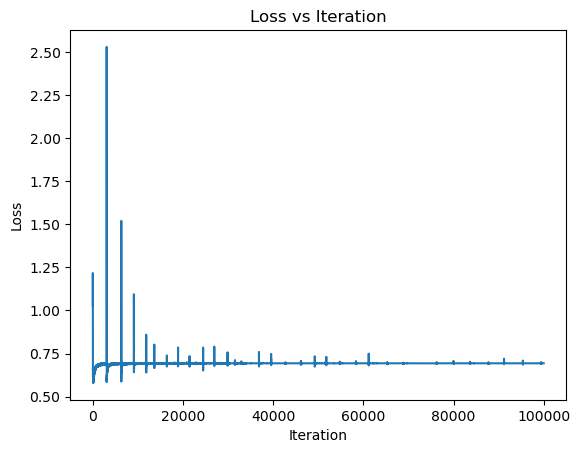

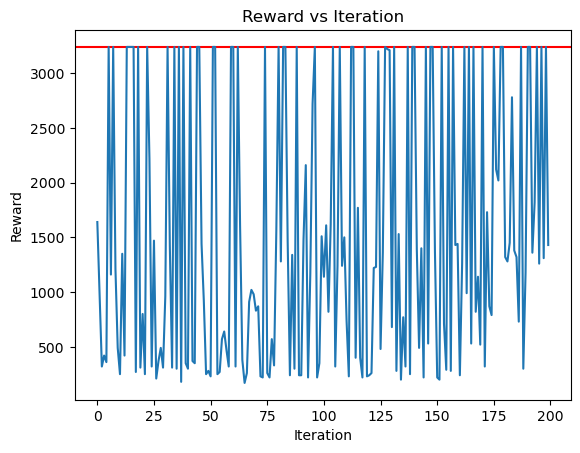

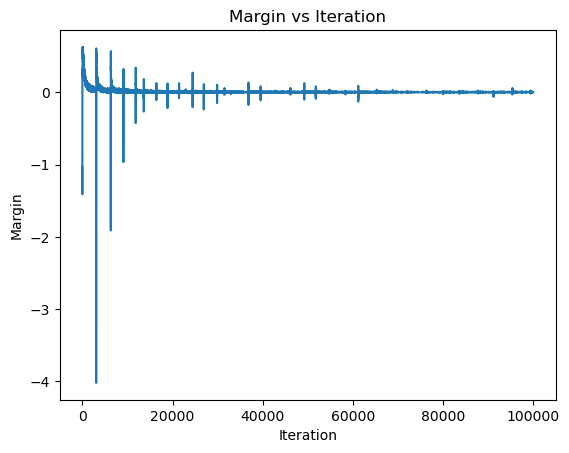

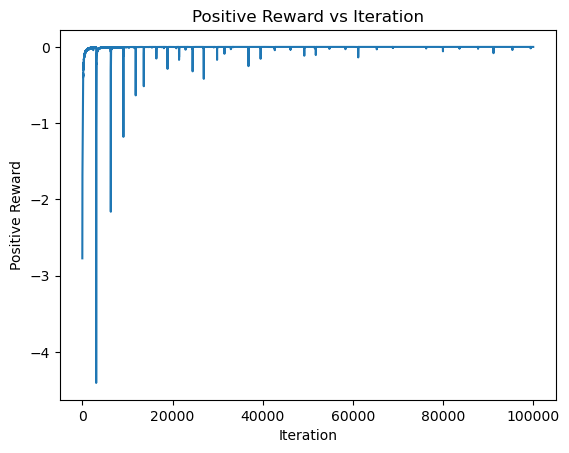

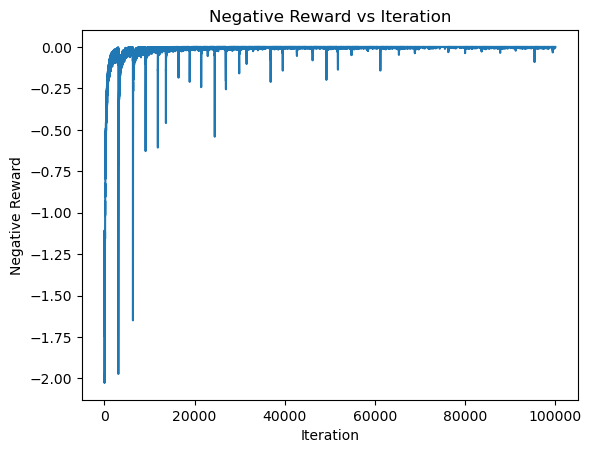

In [25]:
# save all png to /mnt/nfs/work/albertliu/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./loss.png")

plt.show()



# draw the reward graph
# draw a horizontal line at y=3240 which is the expert reward
plt.axhline(y=3240, color='r', linestyle='-', label="Expert Reward")
plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.savefig("./reward.png")
plt.show()

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.savefig("./margin.png")

plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.savefig("./positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")

plt.savefig("./negative_reward.png")
plt.show()


In [23]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/"+env_id+"_28000_rewards.png")
# plt.imshow(img)
# plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MsPacmanNoFrameskip-v4_28000_rewards.png'